### Load the dataset

In [1]:
import numpy as np
import pandas as pd

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.columns = [_.lower() for _ in train.columns]
test.columns = [_.lower() for _ in test.columns]
print('train.shape: {}'.format(train.shape))
print('test.shape: {}'.format(test.shape))

train.shape: (26729, 10)
test.shape: (11456, 8)


### Fill in missing values & Feature engineering

#### Drop the useless attribute outcomesubtype

In [3]:
train = train.drop('outcomesubtype', axis=1)

#### Combine the training and testing data for easy processing

In [4]:
tmp_train = train.drop(['animalid', 'outcometype'], axis=1)
tmp_test = test.drop('id', axis=1)
sep = tmp_train.shape[0]
combine = pd.concat([tmp_train, tmp_test], axis=0)
print('combine.shape: {}'.format(combine.shape))

combine.shape: (38185, 7)


In [5]:
combine.head()

,name,datetime,animaltype,sexuponoutcome,ageuponoutcome,breed,color
0,Hambone,2014-02-12 18:22:00,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,Emily,2013-10-13 12:44:00,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,Pearce,2015-01-31 12:28:00,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,NaN,2014-07-11 19:09:00,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,NaN,2013-11-15 12:52:00,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


#### Create the hasname attribute and drop the original name

In [6]:
combine['hasname'] = combine.name.notnull().astype(int)
combine = combine.drop('name', axis=1)

#### Get the time attributes and drop the original datetime

In [7]:
combine['datetime'] = pd.to_datetime(combine.datetime)
combine['year'] = combine.datetime.dt.year
combine['month'] = combine.datetime.dt.month
combine['day'] = combine.datetime.dt.day
combine['hour'] = combine.datetime.dt.hour
combine = combine.drop('datetime', axis=1)

#### Use 'intact' to replace 'sexuponoutcome'

In [8]:
combine['intact'] = combine.sexuponoutcome.fillna('Unknown').map({
    'Neutered Male': 0,
    'Spayed Female': 0,
    'Intact Male': 1,
    'Intact Female': 1,
    'Unknown': 1
})
combine['sex_only'] = combine.sexuponoutcome.fillna('Unknown').map({
    'Neutered Male': 'Male',
    'Spayed Female': 'Female',
    'Intact Male': 'Male',
    'Intact Female': 'Female',
    'Unknown': 'Unknown'
}).astype('category').cat.codes
combine = combine.drop('sexuponoutcome', axis=1)

#### Transfer animaltype into a binary attribute, use 1 to represent dog

In [9]:
combine['animaltype'] = combine.animaltype.apply(lambda x: int(x=='Dog'))

#### Transfer sexuponoutcome into days and fill in the missing values

In [10]:
def age_transfer(age_str):
    num = age_str.split(' ')[0]
    num = int(num)
    if 'day' in age_str:
        return num
    elif 'week' in age_str:
        return num * 7
    elif 'month' in age_str:
        return num * 30
    elif 'year' in age_str:
        return num * 365
    else:
        return np.nan
    
combine['ageuponoutcome'] = combine.ageuponoutcome.fillna('0').apply(age_transfer)
combine['ageuponoutcome'] = combine.groupby(['animaltype', 'intact']).ageuponoutcome.transform(lambda x: x.fillna(x.median()))

#### Extract some attributes from breed

In [11]:
# Hair
combine['hair'] = combine.breed.str.extract(r'(\w+)\s?[hH]air', expand=False).fillna('Unclear').astype('category').cat.codes

# Mix
combine['mix'] = combine.breed.str.contains('Mix').astype(int)

# Domestic
combine['domestic'] = combine.breed.str.contains('Domestic').astype(int)
    
# Drop the original
combine = combine.drop('breed', axis=1)

#### Create attribute 'morethanonecolor' from color and drop color attribute

In [12]:
combine['morethanonecolor'] = combine.color.str.contains('/').astype(int)

combine = combine.drop('color', axis=1)

In [13]:
combine.head()

,animaltype,ageuponoutcome,hasname,year,month,day,hour,intact,sex_only,hair,mix,domestic,morethanonecolor
0,1,365.0,1,2014,2,12,18,0,1,4,1,0,1
1,0,365.0,1,2013,10,13,12,0,0,3,1,1,0
2,1,730.0,1,2015,1,31,12,0,1,4,1,0,1
3,0,21.0,0,2014,7,11,19,1,1,3,1,1,0
4,1,730.0,0,2013,11,15,12,0,1,4,0,0,0


### Prepare the data for modeling

In [14]:
X_train = combine[:sep]
y_train = train['outcometype']
X_test = combine[sep:]

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

### Set up the metric

In [16]:
mt = 'neg_log_loss'
kf = StratifiedKFold(n_splits=8, shuffle=True, random_state=0)

In [17]:
def performance(model):
    scores = - cross_val_score(model, X_train, y_train, cv=kf, scoring=mt, n_jobs=4)
    print('score mean: {:.4f}'.format(scores.mean()))
    print('score std: {:.4f}'.format(scores.std()))
    
def grid_search(model, params):
    grid = GridSearchCV(model, params, cv=kf, scoring=mt, verbose=True, n_jobs=4).fit(X_train, y_train)
    print('grid.best_score_:{:.4f}'.format(- grid.best_score_))
    print('grid.best_params_:\n{}'.format(grid.best_params_))
    return grid.best_estimator_

### Get the baselines

In [18]:
%%time
performance(LGBMClassifier())

score mean: 0.7656
score std: 0.0154
Wall time: 37 s


In [19]:
%%time
performance(RandomForestClassifier(n_estimators=100))

score mean: 0.9978
score std: 0.0538
Wall time: 18.5 s


In [20]:
performance(VotingClassifier([
    ('lgb_clf', LGBMClassifier()),
    ('rdf_clf', RandomForestClassifier(n_estimators=100)),
], voting='soft'))

score mean: 0.7594
score std: 0.0161


### Search for the best parameters

In [21]:
params = {
    'random_state': [0],
    'n_estimators': [100],
    'max_depth': [13],
    'min_samples_split': [3],
    'max_features': [0.4]
}
rdf_clf = grid_search(RandomForestClassifier(), params)

Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:   23.3s finished


grid.best_score_:0.7733
grid.best_params_:
{'max_depth': 13, 'max_features': 0.4, 'min_samples_split': 3, 'n_estimators': 100, 'random_state': 0}


In [22]:
params = {
    'random_state': [0],
    'n_estimators': [1000],
    'learning_rate': [0.03],
    'num_leaves': [38],
    'max_depth': [16],
    'reg_alpha': [1e-7],
    'reg_lambda': [1],
    'subsample': [0.1],
    'colsample_bytree': [0.9]
}

lgb_clf = grid_search(LGBMClassifier(), params)

Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:  3.8min finished


grid.best_score_:0.7543
grid.best_params_:
{'colsample_bytree': 0.9, 'learning_rate': 0.03, 'max_depth': 16, 'n_estimators': 1000, 'num_leaves': 38, 'random_state': 0, 'reg_alpha': 1e-07, 'reg_lambda': 1, 'subsample': 0.1}


In [23]:
performance(VotingClassifier([
    ('lgb_clf', lgb_clf),
    ('rdf_clf', rdf_clf)
], voting='soft'))

score mean: 0.7494
score std: 0.0162


In [24]:
vote_clf = VotingClassifier([
    ('lgb_clf', lgb_clf),
    ('rdf_clf', rdf_clf)
], voting='soft').fit(X_train, y_train)

### Feature importance

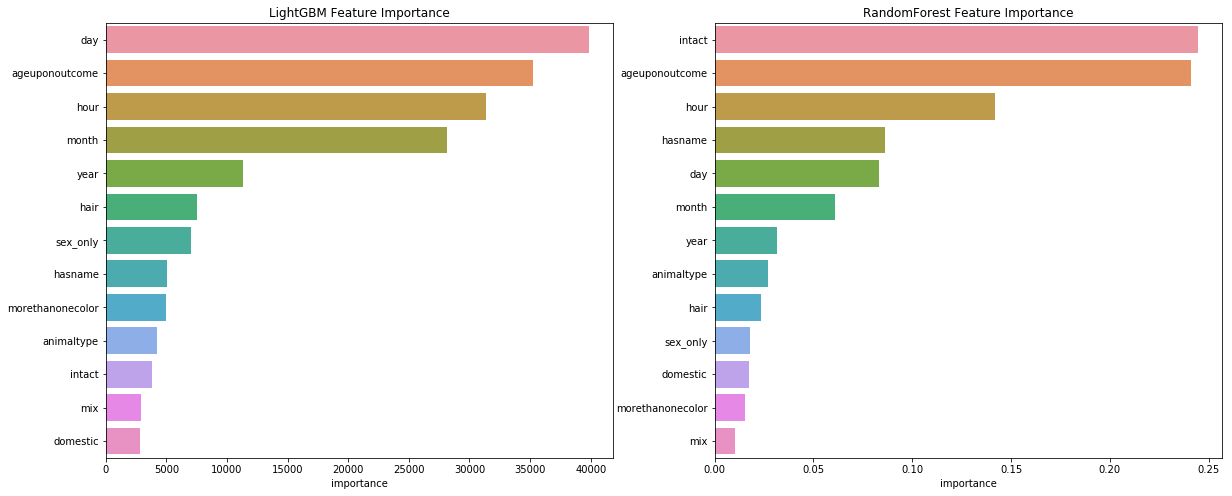

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
for i, title in enumerate(['LightGBM Feature Importance', 'RandomForest Feature Importance']):
    plt.subplot(1, 2, i+1)
    clf = vote_clf.estimators_[i]
    feature_importance = clf.feature_importances_
    feature_importance = pd.Series(feature_importance, index=X_train.columns).reset_index()
    feature_importance.columns = ['feature', 'importance']
    feature_importance = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.ylabel(None)
    plt.title(title)
plt.show()

### Make submission

In [36]:
test_id = pd.Series(test.id.values, name='ID')
y_pred = vote_clf.fit(X_train, y_train).predict_proba(X_test)
y_pred = pd.DataFrame(y_pred, columns=vote_clf.classes_)
sub = pd.concat([test_id, y_pred], axis=1)
sub.to_csv('sub.csv', index=False)